**Testing Classification Models**

# Imports

## Libraries

In [272]:
import os
import pandas as pd
import glob
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
import numpy as np
import librosa
import numba 
from numba import jit
import warnings # from https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
from functions import *
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import seaborn as sns
import speechpy
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, EasyEnsembleClassifier
import sklearn
import pickle
import keras
from keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D, Embedding, MaxPooling1D, Flatten
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping,ModelCheckpoint
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import itertools
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
import math

## Dataframe

In [2]:
df = pd.read_csv("combined_corrected_textgrids", index_col= 0)

# Random Forest Using Hampel Filter

For this section, I'll use the Hampel Filter as one of many features used to determine whether a piece of an audio files is a vowel or not. Here are the features I'll use:
- Whether if passes the  Hampel Filter
- The speaker (unclear actually, if the audio was single channel, then yes)
- Each of the MFCC values 

## Making DataFrame for all of corrected textgrid

Making the hampel filter and mfcc features into the same time scale needs to be addressed first. Doing it this way, will give us a feature "passed_hampel_filter" while having other information to draw on.

#### Getting full length audio

In [3]:
long_audio, sr = librosa.load("./original_en_diapix_data/DP_ENF_02_ENF_06_EN_ENF_02_DP_ENF_02_ENF_06_EN_ENF_06.wav", sr = 8000)

### Getting mfcc for whole file

In [4]:
# 200 samples per second
0.025*8000

200.0

In [5]:
mfcc_long_audio = speechpy.feature.mfcc(signal = long_audio, sampling_frequency = 8000, frame_length = 0.025, 
                             frame_stride = 0.025)

In [6]:
len(mfcc_long_audio)

21103

#### examining output of mfcc

In [7]:
mfcc_long_audio.shape

(21103, 13)

In [8]:
mfcc_long_audio[0]

array([-36.04365339,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ])

#### Turning into a dataframe
https://stackoverflow.com/questions/20763012/creating-a-pandas-dataframe-from-a-numpy-array-how-do-i-specify-the-index-colum

In [9]:
cols = ['MFCC_'+str(i) for i in range(1, 13+1)]

In [10]:
cols[0:3]

['MFCC_1', 'MFCC_2', 'MFCC_3']

In [11]:
mfcc_df = pd.DataFrame(data = mfcc_long_audio[0:,0:], columns = cols)

In [12]:
mfcc_df.head(2)

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13
0,-36.043653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-36.043653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# length of the file divided by 40 equals time length of file
21103/40

527.575

In [14]:
len(mfcc_df) / 527.575

40.0

### Adding Hampel Filter to this dataframe

#### Running hampel filter over entire file using same window length as mfcc and low hampel filter value

In [15]:
# as found in 2.1.2 getting mfcc for whole file, there are 200 samples per second 
# we'll use this value so that the middle sample is entirely within the mfcc sample, 
# but all other values will be looking outside mfcc

In [16]:
window200_sigma1 = hampel_filter_forloop_numba(long_audio, 200, n_sigmas=1)

In [17]:
len(window200_sigma1[0]) / 8000

527.60425

In [18]:
window200_sigma1_binary = make_results_into_binary(window200_sigma1[1], number_of_possible_samples_in_file = len(window200_sigma1[0]))

In [19]:
# definitely found (what it thinks are) vowels! 
window200_sigma1_binary.sum()

1279737.0

In [20]:
len(window200_sigma1_binary)

4220834

#### Chunking the indices to 200 samples per second 

In [21]:
window200_sigma1_percent_passing = make_sample_rates_match(window200_sigma1[1], 40, 21103)

In [22]:
len(window200_sigma1_percent_passing)

21103

#### Adding the hampel filter percentage to the df

In [23]:
mfcc_df['Percent_passing_hampel_filter'] = window200_sigma1_percent_passing

In [24]:
# it worked! 
mfcc_df.head(4)

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13,Percent_passing_hampel_filter
0,-36.043653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-36.043653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-36.043653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-36.043653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
mfcc_df['Percent_passing_hampel_filter'].mean()

0.30481542908591197

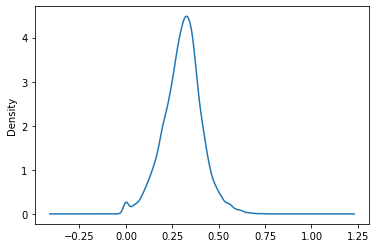

In [26]:
mfcc_df['Percent_passing_hampel_filter'].plot.kde()

#### Saving this dataframe

In [27]:
# mfcc_df.to_csv("./corrected_textgrid/mfcc_hamp_filter_df/df")

### Making prediction column (vowel/not vowel for correct time points)

In [28]:
only_vowels_df = df[df['Vowel']==1].reset_index()

In [29]:
only_vowels_df.head(2)

,index,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speaker,Phone_Duration
0,2,AH,4.589832,4.831125,!SIL,2.000000,4.361218,1,6,0.241293
1,5,AY,5.481125,5.881125,mine,5.141125,6.111125,1,6,0.400000


In [30]:
#I have to limit the df to vowels either in the function, or before I input the df
vowel_indices = chunk_vowels_to_sr(only_vowels_df)

In [31]:
len(vowel_indices) / 40

25998.875

In [32]:
vowel_indices[0:10]

[36719, 36720, 36721, 36722, 36723, 36724, 36725, 36726, 36727, 36728]

In [33]:
vowel_indices_percent_passing = make_sample_rates_match(vowel_indices, 40, 21103)

In [34]:
sum(vowel_indices_percent_passing)

5206.340000000007

In [35]:
len(vowel_indices_percent_passing)

21103

#### Make into binary classification (currently a percentage)

##### Trying to find distribution of values in vowel_indices_percent_passing

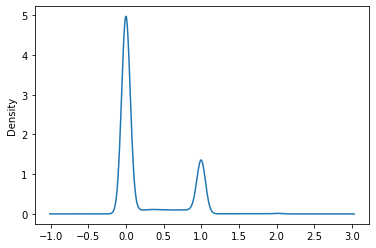

In [36]:
vowel_indices_percent_passing_series = pd.Series(vowel_indices_percent_passing)
ax = vowel_indices_percent_passing_series.plot.kde()

In [37]:
type(vowel_indices_percent_passing)

list

In [38]:
vowel_indices_percent_passing_array = np.array(vowel_indices_percent_passing)

In [39]:
# finding percent of values that are above 0
counter = 0
for x in vowel_indices_percent_passing:
    if x > 0.5:
        counter+=1
counter

5097

In [40]:
vowel_indices_binary = np.where(vowel_indices_percent_passing_array > 0.5, 1, 0)

In [41]:
vowel_indices_binary.sum()

5097

### Formally making test/ train split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(mfcc_df, vowel_indices_binary, test_size=0.33, random_state=1)

## Building Random Forest Model

### Function to find and calculate metrics

In [43]:
metric_dictionary = {}

### Model 1

In [44]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1,
                           verbose = 1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [45]:
metric_dictionary = find_metrics(y_test, rf_pred, metric_dictionary, 'first_random_forest')

      
        The f1 score is 0.728. 

        The recall_score is 0.706. 

        The precision is 0.752. 


In [47]:
metric_dictionary

{'first_random_forest': {'f1_score': 0.728,
  'recall_score': 0.706,
  'precision_score': 0.752}}

### Model 2

In [48]:
# trying more estimators 
rf2 = RandomForestClassifier(n_estimators = 10000, random_state = 42, n_jobs=-1,
                           verbose = 1)
rf2.fit(X_train, y_train)
rf_pred2 = rf2.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 10000 out of 

In [49]:
metric_dictionary = find_metrics(y_test, rf_pred2, metric_dictionary, 'second_random_forest')

      
        The f1 score is 0.736. 

        The recall_score is 0.719. 

        The precision is 0.755. 


In [50]:
random_forest_cm2 = confusion_matrix(y_test, rf_pred2)
print(random_forest_cm2)

[[4838  403]
 [ 484 1239]]


### Model 3

In [51]:
# lower level of nodes, class_weight='balanced_subsample'
# trying more estimators 
rf3 = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1,
                            class_weight='balanced_subsample')
rf3.fit(X_train, y_train)
rf_pred3 = rf3.predict(X_test)

In [54]:
metric_dictionary = find_metrics(y_test, rf_pred3, metric_dictionary, 'third_random_forest')

      
        The f1 score is 0.723. 

        The recall_score is 0.685. 

        The precision is 0.764. 


### Model 4

In [55]:
# BalancedRandomForestClassifier 
rf4 = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf4.fit(X_train, y_train)
rf_pred4 = rf4.predict(X_test)

In [432]:
# sorted(sklearn.metrics.SCORERS.keys())
# this method isn't very helpful compare to computing f1 score
# print(cross_val_score(rf4, X_train, y_train, cv=5, scoring='f1'))

In [56]:
metric_dictionary = find_metrics(y_test, rf_pred4, metric_dictionary, 'fourth_random_forest')

      
        The f1 score is 0.734. 

        The recall_score is 0.917. 

        The precision is 0.612. 


### Model 5 - class_weight = 'balanced'

In [57]:
rf5 = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1,
                            class_weight='balanced')
rf5.fit(X_train, y_train)
rf_pred5 = rf5.predict(X_test)

In [58]:
metric_dictionary = find_metrics(y_test, rf_pred5, metric_dictionary, 'fifth_random_forest')

      
        The f1 score is 0.727. 

        The recall_score is 0.694. 

        The precision is 0.764. 


## Bagging algorithms

### Model 1: Base 

In [59]:
bagging_model = BaggingClassifier(n_estimators=100, random_state=42, n_jobs=-1)
bagging_model.fit(X_train, y_train)
bagging_model_predictions = bagging_model.predict(X_test)

In [60]:
metric_dictionary = find_metrics(y_test, bagging_model_predictions, metric_dictionary, 'first_bagged_model')

      
        The f1 score is 0.736. 

        The recall_score is 0.723. 

        The precision is 0.749. 


### Model 2: balanced bagging 

In [61]:
balanced_bagging_model = BalancedBaggingClassifier(n_estimators = 100, random_state=42, n_jobs=-1)
balanced_bagging_model.fit(X_train, y_train)
balanced_bagging_model_predictions = balanced_bagging_model.predict(X_test)

In [62]:
metric_dictionary = find_metrics(y_test, balanced_bagging_model_predictions, metric_dictionary, 'second_bagged_model')

      
        The f1 score is 0.746. 

        The recall_score is 0.867. 

        The precision is 0.654. 


## Ensemble Methods

### Model 1

In [63]:
ensemb_model = EasyEnsembleClassifier(n_estimators=100, random_state=42, n_jobs=-1)
ensemb_model.fit(X_train, y_train)
ensemb_model_predictions = ensemb_model.predict(X_test)

In [64]:
metric_dictionary = find_metrics(y_test, ensemb_model_predictions, metric_dictionary, 'first_ensemble_model')

      
        The f1 score is 0.707. 

        The recall_score is 0.918. 

        The precision is 0.575. 


## Random Forest with SMOTE

In [65]:
oversample3 = SMOTE(sampling_strategy=0.7)

In [66]:
X_train_oversample3, y_train_oversample3 = oversample3.fit_resample(X_train, y_train)

In [67]:
# ratio of 40/60 vowel / nonvowel
y_train_oversample3.sum() / len(y_train_oversample3)

0.41174863387978144

In [68]:
rf_sm = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1,
                           verbose = 1)
rf_sm.fit(X_train_oversample3, y_train_oversample3)
rf_pred_sm = rf_sm.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [69]:
metric_dictionary = find_metrics(y_test, rf_pred_sm, metric_dictionary, 'random_forest_w_smote')

      
        The f1 score is 0.755. 

        The recall_score is 0.81. 

        The precision is 0.708. 


## Picking best model

In [70]:
best_f1 = 0
best_model_list = []
for item in metric_dictionary:
    if metric_dictionary[item]['f1_score'] > best_f1:
        best_f1 = metric_dictionary[item]['f1_score']
        best_model_list.append(item)
print(best_model_list[-1])
print(best_f1)

random_forest_w_smote
0.755


In [73]:
# metric_dictionary

## Improving Best Model

In [201]:
# adding more trees for current best model 
random_forest_w_smote2 = RandomForestClassifier(n_estimators = 1000, random_state = 42, n_jobs=-1,
                           verbose = 1)
random_forest_w_smote2.fit(X_train_oversample3, y_train_oversample3)
random_forest_w_smote_predictions2 = random_forest_w_smote2.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [202]:
metric_dictionary = find_metrics(y_test, random_forest_w_smote_predictions2, metric_dictionary, 'random_forest_w_smote2')

      
        The f1 score is 0.761. 

        The recall_score is 0.818. 

        The precision is 0.712. 


# Saving models/data

In [531]:
# with open('./corrected_textgrid/data_for_final_model/vowel_indices', "wb+") as f:
#     pickle.dump(vowel_indices, f)

In [528]:
# test_train_split = "X_train, X_test, y_train, y_test = train_test_split(mfcc_df, vowel_indices_binary, test_size=0.33, random_state=1)"
# with open('./corrected_textgrid/data_for_final_model/test_train_split', "wb+") as f:
#     pickle.dump(test_train_split, f)

In [529]:
# best_model_info = """
# balanced_bagging_model2 = BalancedBaggingClassifier(n_estimators = 10000, random_state=42, n_jobs=-1)
# balanced_bagging_model2.fit(X_train, y_train)
# balanced_bagging_model_predictions2 = balanced_bagging_model2.predict(X_test)
# """

In [530]:
# with open('./corrected_textgrid/data_for_final_model/best_model_info', "wb+") as f:
#     pickle.dump(best_model_info, f)

In [ ]:
# why is there such a difference in the size of the two test/train/splits? 
## --- I think it's because I ran it on the new_indices that the hampel filter makes (only median values)
## --- instead of the original data 
# _ I think the answer is that I made a mistake when I was finding the test/validate/train split point

# Neural Networks

## Getting data

In [78]:
X_train, X_test, y_train, y_test = train_test_split(mfcc_df, vowel_indices_binary, test_size=0.33, random_state=1)

In [79]:
X_train.shape

(14139, 14)

In [80]:
y_train.shape

(14139,)

## Vanilla Neural Networks

### Model 1 - no upsample

In [81]:
# Initialize a sequential model
model = Sequential()
# Two layers with relu activation 8 layers
model.add(Dense(50, activation='relu', input_shape=(14,)))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='tanh'))
model.add(Dense(25, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(25, activation='tanh'))
model.add(Dense(25, activation='relu'))
# One layer with sigmoid activation 
model.add(Dense(1, activation='sigmoid'))

In [82]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [107]:
es = EarlyStopping(monitor = 'acc', mode = 'auto', patience = 3, min_delta = 0.05)
mcb = ModelCheckpoint('history', monitor= 'acc', mode = 'auto', verbose = 1, save_best_only=True)

In [108]:
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=75,
                   callbacks = [es, mcb])

Epoch 1/75
14139/14139 [==============================] - 0s 31us/step - loss: 0.1965 - acc: 0.9156

Epoch 00001: acc improved from -inf to 0.91562, saving model to history
Epoch 2/75
14139/14139 [==============================] - 0s 26us/step - loss: 0.1970 - acc: 0.9156

Epoch 00002: acc did not improve from 0.91562
Epoch 3/75
14139/14139 [==============================] - 0s 25us/step - loss: 0.1974 - acc: 0.9142

Epoch 00003: acc did not improve from 0.91562
Epoch 4/75
14139/14139 [==============================] - 0s 28us/step - loss: 0.1980 - acc: 0.9163

Epoch 00004: acc improved from 0.91562 to 0.91626, saving model to history


In [109]:
#history
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc'])

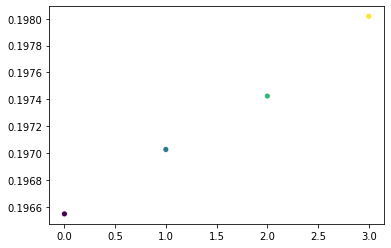

In [110]:
# Plot the loss vs the number of epoch
sns.scatterplot(x = range(len(history_dict['loss'])), y=history_dict['loss'])

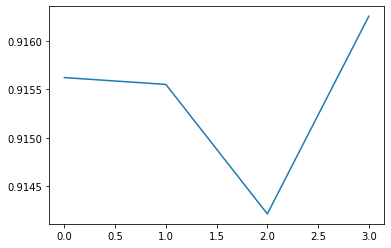

In [111]:
# Plot the training accuracy vs the number of epochs
sns.lineplot(x = range(len(history_dict['acc'])), y=history_dict['acc'])

In [112]:
# Output (probability) predictions for the test set 
y_hat_test = model.predict(X_test)

In [113]:
# Print the loss and accuracy for the training set 
results_train = model.evaluate(X_train, y_train)
results_train

14139/14139 [==============================] - 0s 17us/step


[0.18337407745160092, 0.9233326260823831]

In [114]:
# Print the loss and accuracy for the test set (it prints the evaluation metric values given to it)
results_test = model.evaluate(X_test, y_test)
results_test

6964/6964 [==============================] - 0s 17us/step


[0.3511136650080519, 0.8589890867659993]

In [117]:
ynew = model.predict_classes(X_test)
print(classification_report(y_test, ynew))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      5241
           1       0.73      0.68      0.70      1723

    accuracy                           0.86      6964
   macro avg       0.81      0.80      0.81      6964
weighted avg       0.86      0.86      0.86      6964



In [118]:
model1_confusionmatrix = confusion_matrix(y_test, ynew)
model1_confusionmatrix

array([[4811,  430],
       [ 552, 1171]])

In [119]:
metric_dictionary = find_metrics(y_test, ynew, metric_dictionary, 'first_vanilla_network')

      
        The f1 score is 0.705. 

        The recall_score is 0.68. 

        The precision is 0.731. 


### Model 2 - class weighting

#### What are the proportion of non-vowels to vowels

In [104]:
# approximately a 1:4 ratio
len(y_test) / y_test.sum()

4.04178757980267

#### Class weight dictionary to add to the model

In [124]:
# making the values the inverse of the proportion so that vowels are weighted more strongly
weights = {0:1, 1:4}

#### The model

In [125]:
# Initialize a sequential model
model2 = Sequential()
# Two layers with relu activation 8 layers
model2.add(Dense(50, activation='relu', input_shape=(14,)))
model2.add(Dense(25, activation='relu'))
model2.add(Dense(25, activation='tanh'))
model2.add(Dropout(0.1))
model2.add(Dense(25, activation='relu'))
model2.add(Dense(25, activation='tanh'))
model2.add(Dense(25, activation='relu'))
# model.add(Dropout(0.1))
model2.add(Dense(25, activation='tanh'))
model2.add(Dense(25, activation='relu'))
# One layer with sigmoid activation 
model2.add(Dense(1, activation='sigmoid'))

In [126]:
# Compile the model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [128]:
history2 = model2.fit(X_train, y_train,
                    batch_size=64,
                    epochs=75,
                   callbacks = [es, mcb],
                    class_weight=weights)

Epoch 1/75
14139/14139 [==============================] - 1s 59us/step - loss: 0.6957 - acc: 0.7709

Epoch 00001: acc improved from -inf to 0.77092, saving model to history
Epoch 2/75
14139/14139 [==============================] - 0s 28us/step - loss: 0.5929 - acc: 0.8020

Epoch 00002: acc improved from 0.77092 to 0.80197, saving model to history
Epoch 3/75
14139/14139 [==============================] - 0s 26us/step - loss: 0.5725 - acc: 0.8115

Epoch 00003: acc improved from 0.80197 to 0.81151, saving model to history
Epoch 4/75
14139/14139 [==============================] - 0s 25us/step - loss: 0.5621 - acc: 0.8219

Epoch 00004: acc improved from 0.81151 to 0.82191, saving model to history
Epoch 5/75
14139/14139 [==============================] - 0s 25us/step - loss: 0.5506 - acc: 0.8234

Epoch 00005: acc improved from 0.82191 to 0.82340, saving model to history
Epoch 6/75
14139/14139 [==============================] - 0s 25us/step - loss: 0.5514 - acc: 0.8305

Epoch 00006: acc impro

In [129]:
#history
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'acc'])

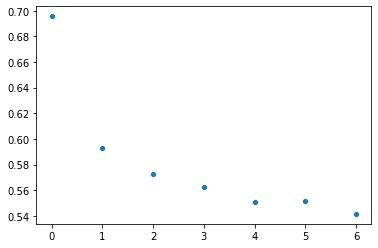

In [130]:
# Plot the loss vs the number of epoch
sns.scatterplot(x = range(len(history_dict2['loss'])), y=history_dict2['loss'])

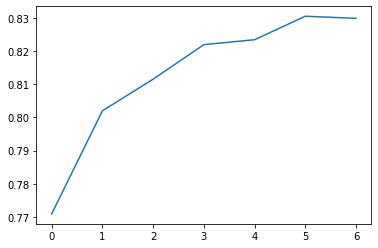

In [131]:
# Plot the training accuracy vs the number of epochs
sns.lineplot(x = range(len(history_dict2['acc'])), y=history_dict2['acc'])

In [132]:
# Output (probability) predictions for the test set 
y_hat_test2 = model2.predict(X_test)

In [133]:
# Print the loss and accuracy for the training set 
results_train2 = model2.evaluate(X_train, y_train)
results_train2

14139/14139 [==============================] - 0s 24us/step


[0.34735357873729317, 0.8266496923234727]

In [134]:
# Print the loss and accuracy for the test set (it prints the evaluation metric values given to it)
results_test2 = model2.evaluate(X_test, y_test)
results_test2

6964/6964 [==============================] - 0s 18us/step


[0.37551647811563177, 0.8179207351411779]

In [135]:
ynew2 = model2.predict_classes(X_test)
print(classification_report(y_test, ynew2))

              precision    recall  f1-score   support

           0       0.97      0.78      0.87      5241
           1       0.58      0.92      0.71      1723

    accuracy                           0.82      6964
   macro avg       0.78      0.85      0.79      6964
weighted avg       0.87      0.82      0.83      6964



In [136]:
model1_confusionmatrix2 = confusion_matrix(y_test, ynew2)
model1_confusionmatrix2

array([[4106, 1135],
       [ 133, 1590]])

In [137]:
# no difference from first model
metric_dictionary = find_metrics(y_test, ynew2, metric_dictionary, 'second_vanilla_network')

      
        The f1 score is 0.715. 

        The recall_score is 0.923. 

        The precision is 0.583. 


## Upsampling Vowels

In [139]:
# upsampling on the training data 
oversample = SMOTE()
X_train_oversample, y_train_oversample = oversample.fit_resample(X_train, y_train)

In [140]:
len(X_train_oversample)

21530

In [141]:
len(X_train)

14139

### Model 3

In [164]:
# Initialize a sequential model
model3 = Sequential()
# Two layers with relu activation 8 layers
model3.add(Dense(50, activation='relu', input_shape=(14,)))
model3.add(Dense(25, activation='relu'))
model3.add(Dense(25, activation='tanh'))
model3.add(Dropout(0.1))
model3.add(Dense(25, activation='relu'))
model3.add(Dense(25, activation='tanh'))
model3.add(Dense(25, activation='relu'))
# model.add(Dropout(0.1))
model3.add(Dense(25, activation='tanh'))
model3.add(Dense(25, activation='relu'))
# One layer with sigmoid activation 
model3.add(Dense(1, activation='sigmoid'))

In [165]:
# Compile the model
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [166]:
history3 = model3.fit(X_train_oversample, y_train_oversample,
                    batch_size=64,
                    epochs=75,
                   callbacks = [es, mcb])

Epoch 1/75
21530/21530 [==============================] - 1s 53us/step - loss: 0.3748 - acc: 0.8428

Epoch 00001: acc did not improve from 0.86651
Epoch 2/75
21530/21530 [==============================] - 1s 27us/step - loss: 0.3330 - acc: 0.8622

Epoch 00002: acc did not improve from 0.86651
Epoch 3/75
21530/21530 [==============================] - 1s 28us/step - loss: 0.3236 - acc: 0.8687

Epoch 00003: acc improved from 0.86651 to 0.86869, saving model to history
Epoch 4/75
21530/21530 [==============================] - 1s 28us/step - loss: 0.3174 - acc: 0.8689

Epoch 00004: acc improved from 0.86869 to 0.86893, saving model to history


In [167]:
#history
history_dict3 = history3.history
history_dict3.keys()

dict_keys(['loss', 'acc'])

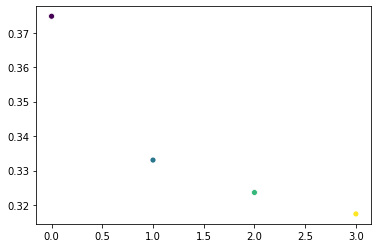

In [168]:
# Plot the loss vs the number of epoch
sns.scatterplot(x = range(len(history_dict3['loss'])), y=history_dict3['loss'])

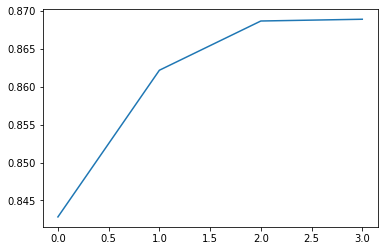

In [169]:
# Plot the training accuracy vs the number of epochs
sns.lineplot(x = range(len(history_dict3['acc'])), y=history_dict3['acc'])

In [170]:
# Output (probability) predictions for the test set 
y_hat_test3 = model3.predict(X_test)

In [171]:
# Print the loss and accuracy for the training set 
results_train3 = model3.evaluate(X_train_oversample, y_train_oversample)
results_train3

21530/21530 [==============================] - 1s 28us/step


[0.30977009245256354, 0.8705991639628058]

In [172]:
# Print the loss and accuracy for the test set (it prints the evaluation metric values given to it)
results_test3 = model3.evaluate(X_test, y_test)
results_test3

6964/6964 [==============================] - 0s 22us/step


[0.3165405469335132, 0.8558299828369955]

In [173]:
ynew3 = model3.predict_classes(X_test)
print(classification_report(y_test, ynew3))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      5241
           1       0.66      0.84      0.74      1723

    accuracy                           0.86      6964
   macro avg       0.80      0.85      0.82      6964
weighted avg       0.87      0.86      0.86      6964



In [174]:
model1_confusionmatrix3 = confusion_matrix(y_test, ynew3)
model1_confusionmatrix3

array([[4505,  736],
       [ 268, 1455]])

In [175]:
# wow! this works amazingly well! 
metric_dictionary = find_metrics(y_test, ynew3, metric_dictionary, 'vanilla_network_w_upsample')

      
        The f1 score is 0.743. 

        The recall_score is 0.844. 

        The precision is 0.664. 


## Upsampling with Undersampling Examples 

In [176]:
# changing the training samples, not the test samples
oversample2 = SMOTE(sampling_strategy=0.6)
under = RandomUnderSampler(sampling_strategy=0.7)

In [177]:
X_train_over2, y_train_over2 = oversample2.fit_resample(X_train, y_train)

In [178]:
X_train_under_over, y_train_under_over = under.fit_resample(X_train_over2, y_train_over2)

In [179]:
len(X_train)

14139

In [180]:
len(X_train_over2)

17224

In [181]:
len(X_train_under_over)

15686

#### Getting ratio between the two classes now

In [182]:
y_train_under_over.sum() / len(y_train_under_over)

0.4117684559479791

Now we have a 40/60 split of vowels to non-vowels

### Model 4

In [183]:
# Initialize a sequential model
model4 = Sequential()
# Two layers with relu activation 8 layers
model4.add(Dense(50, activation='relu', input_shape=(14,)))
model4.add(Dense(25, activation='relu'))
model4.add(Dense(25, activation='tanh'))
model4.add(Dropout(0.1))
model4.add(Dense(25, activation='relu'))
model4.add(Dense(25, activation='tanh'))
model4.add(Dense(25, activation='relu'))
# model.add(Dropout(0.1))
model4.add(Dense(25, activation='tanh'))
model4.add(Dense(25, activation='relu'))
# One layer with sigmoid activation 
model4.add(Dense(1, activation='sigmoid'))

In [184]:
# Compile the model
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [185]:
history4 = model4.fit(X_train_under_over, y_train_under_over,
                    batch_size=64,
                    epochs=75,
                   callbacks = [es, mcb])

Epoch 1/75
15686/15686 [==============================] - 1s 66us/step - loss: 0.3978 - acc: 0.8142

Epoch 00001: acc did not improve from 0.86893
Epoch 2/75
15686/15686 [==============================] - 0s 28us/step - loss: 0.3387 - acc: 0.8541

Epoch 00002: acc did not improve from 0.86893
Epoch 3/75
15686/15686 [==============================] - 0s 27us/step - loss: 0.3272 - acc: 0.8570

Epoch 00003: acc did not improve from 0.86893
Epoch 4/75
15686/15686 [==============================] - 0s 28us/step - loss: 0.3196 - acc: 0.8606

Epoch 00004: acc did not improve from 0.86893


In [186]:
#history
history_dict4 = history4.history
history_dict4.keys()

dict_keys(['loss', 'acc'])

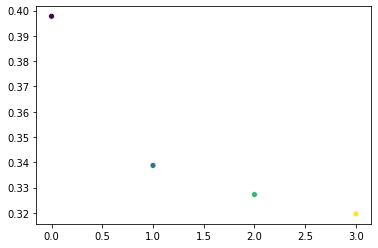

In [187]:
# Plot the loss vs the number of epoch
sns.scatterplot(x = range(len(history_dict4['loss'])), y=history_dict4['loss'])

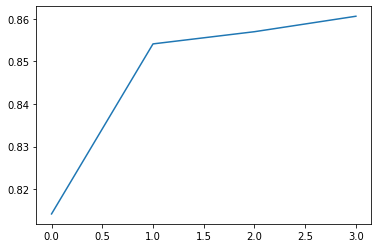

In [188]:
# Plot the training accuracy vs the number of epochs
sns.lineplot(x = range(len(history_dict4['acc'])), y=history_dict4['acc'])

In [189]:
# Output (probability) predictions for the test set 
y_hat_test4 = model4.predict(X_test)

In [190]:
# Print the loss and accuracy for the training set 
results_train4 = model4.evaluate(X_train_under_over, y_train_under_over)
results_train4

15686/15686 [==============================] - 1s 32us/step


[0.30855096066110554, 0.867206426112457]

In [191]:
# Print the loss and accuracy for the test set (it prints the evaluation metric values given to it)
results_test4 = model4.evaluate(X_test, y_test)
results_test4

6964/6964 [==============================] - 0s 24us/step


[0.3128868903085324, 0.8595634692020624]

In [192]:
ynew4 = model4.predict_classes(X_test)
print(classification_report(y_test, ynew4))

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      5241
           1       0.68      0.82      0.74      1723

    accuracy                           0.86      6964
   macro avg       0.81      0.85      0.82      6964
weighted avg       0.87      0.86      0.86      6964



In [193]:
model1_confusionmatrix4 = confusion_matrix(y_test, ynew4)
model1_confusionmatrix4

array([[4565,  676],
       [ 302, 1421]])

In [194]:
# similar though slightly better results than just upsampling
metric_dictionary = find_metrics(y_test, ynew4, metric_dictionary, 'vanilla_network_w_upsample_and_downsample')

      
        The f1 score is 0.744. 

        The recall_score is 0.825. 

        The precision is 0.678. 


## Choosing Best Model

In [203]:
best_f1 = 0
best_model_list = []
for item in metric_dictionary:
    if metric_dictionary[item]['f1_score'] > best_f1:
        best_f1 = metric_dictionary[item]['f1_score']
        best_model_list.append(item)
print(best_model_list[-1])
print(best_f1)

random_forest_w_smote2
0.761


# Conclusion about Classification Models

My best model is a random forest that upsamples data with SMOTE. It has an F1 score of 0.761. The neural networks were also improve by using SMOTE. 

In [204]:
metric_dictionary

{'first_random_forest': {'f1_score': 0.728,
  'recall_score': 0.706,
  'precision_score': 0.752},
 'second_random_forest': {'f1_score': 0.736,
  'recall_score': 0.719,
  'precision_score': 0.755},
 'third_random_forest': {'f1_score': 0.723,
  'recall_score': 0.685,
  'precision_score': 0.764},
 'fourth_random_forest': {'f1_score': 0.734,
  'recall_score': 0.917,
  'precision_score': 0.612},
 'fifth_random_forest': {'f1_score': 0.727,
  'recall_score': 0.694,
  'precision_score': 0.764},
 'first_bagged_model': {'f1_score': 0.736,
  'recall_score': 0.723,
  'precision_score': 0.749},
 'second_bagged_model': {'f1_score': 0.746,
  'recall_score': 0.867,
  'precision_score': 0.654},
 'first_ensemble_model': {'f1_score': 0.707,
  'recall_score': 0.918,
  'precision_score': 0.575},
 'random_forest_w_smote': {'f1_score': 0.755,
  'recall_score': 0.81,
  'precision_score': 0.708},
 'random_forest_w_smote2': {'f1_score': 0.761,
  'recall_score': 0.818,
  'precision_score': 0.712},
 'first_vanill

# Analyzing Results 

- So all of these models were analyzing the individual frames (1/400th of a second) in a random order (therefore, without surrounding context). Vowels in the real world appear as a 25-150 millisecond continuous collection of sounds. Therefore, the frames are somewhat unnatural in terms of making a singular prediction of vowel or not vowel. 
- Here, I'll analyze the predictions of my models to see if my models:
    - make at least one correct prediction over the course of a vowel
    - what are the tendencies of the incorrect predictions: are they sounds similar to vowels?
- Since it will be near impossible to place the upsampled/downsampled predictions in the original order (as far as I am aware), I will work with the best model that does not upsample/downsample: the second bagged model

## Rerunning the model without a shuffled test/train split

In [ ]:
#original test train split was done with this code
# X_train, X_test, y_train, y_test = train_test_split(mfcc_df, vowel_indices_binary, test_size=0.33, random_state=1)

### Finding Split Point

In [218]:
# I will split the first 67% of data as train, and last 33% as test 
split_point = int(len(mfcc_df) * 0.67)

In [306]:
split_point

14139

In [219]:
X_train67 = mfcc_df[:split_point]
y_train67 = vowel_indices_binary[:split_point]
X_test33 = mfcc_df[split_point:]
y_test33 = vowel_indices_binary[split_point:]

### Rerunning the model

In [220]:
balanced_bagging_model2 = BalancedBaggingClassifier(n_estimators = 100, random_state=42, n_jobs=-1)
balanced_bagging_model2.fit(X_train67, y_train67)
balanced_bagging_model_predictions2 = balanced_bagging_model2.predict(X_test33)

In [221]:
metric_dictionary = find_metrics(y_test33, balanced_bagging_model_predictions2, metric_dictionary, 'second_bagged_model_different_split')

      
        The f1 score is 0.725. 

        The recall_score is 0.781. 

        The precision is 0.676. 


## Bringing together the x_test33, y_test33 for the second bagged model

In [224]:
original_df_last_third = X_test33

In [225]:
original_df_last_third['actual_vowels'] = y_test33
original_df_last_third['predicted_vowels'] = balanced_bagging_model_predictions2

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [307]:
original_df_last_third.head(2)

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13,Percent_passing_hampel_filter,actual_vowels,predicted_vowels
14139,-10.098527,4.932286,1.864990,0.316451,-0.312592,-0.995565,-1.099944,-0.379565,-1.390550,-1.055092,0.202184,-0.167304,0.749360,0.08,0,0
14140,-8.468687,12.740945,4.570114,0.603386,-2.683702,-3.259884,-2.459758,-1.270219,0.625708,-0.024474,0.125958,-0.629837,-0.060484,0.37,0,0


### How many vowels were predicted in each column?

In [227]:
original_df_last_third['actual_vowels'].sum()

1554

In [228]:
original_df_last_third['predicted_vowels'].sum()

1796

In [229]:
# make sample rates match? 
# I want all of the vowels to be in the original times of the annotations

In [230]:
df

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speaker,Phone_Duration
0,NaN,0.000000,2.000000,NaN,0.000000,2.000000,0,6,2.000000
1,!SIL,2.000000,4.589832,!SIL,2.000000,4.361218,0,6,2.589832
2,AH,4.589832,4.831125,!SIL,2.000000,4.361218,1,6,0.241293
3,M,4.831125,5.141125,!SIL,2.000000,4.361218,0,6,0.310000
4,M,5.141125,5.481125,mine,5.141125,6.111125,0,6,0.340000
...,...,...,...,...,...,...,...,...,...
3413,K,520.686125,520.726125,!SIL,518.455909,520.326117,0,2,0.040000
3414,EY,520.726125,520.886125,!SIL,518.455909,520.326117,1,2,0.160000
3415,lg,520.886125,521.407062,<LG>,520.886125,521.407062,0,2,0.520937
3416,!SIL,521.407062,525.604172,!SIL,521.407062,525.604172,0,2,4.197110


In [238]:
# first step: finding which section of the df is where the test data starts
# length of file * 0.67 will be beginning time point for test section
beginning_time_point_test = (len(long_audio) / 8000) * 0.67
beginning_time_point_test

353.4948475

In [277]:
test_df = df[df['Phone_xmin'] > beginning_time_point_test].copy()

In [291]:
test_df.head(2)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speaker,Phone_Duration,Total_frames_in_phone
1394,AH,353.988485,354.071,!SIL,343.027075,353.951077,1,6,0.082515,660.11842
1395,P,354.071000,354.211,!SIL,343.027075,353.951077,0,6,0.140000,1120.00000


In [279]:
# test_df covers 174 seconds
(len(long_audio) / 8000) - beginning_time_point_test

174.1094025

#### Finding correct vowel chunks

In [280]:
phone_xmin_array = np.array(test_df['Phone_xmin'])
first_full_phone_in_test_df = phone_xmin_array.min()
first_full_phone_in_test_df

353.98848519748657

In [281]:
first_full_phone_remainder = first_full_phone_in_test_df % 0.025

In [282]:
first_full_phone_remainder

0.013485197486548618

In [283]:
first_full_phone_chunk = first_full_phone_in_test_df - first_full_phone_remainder
first_full_phone_chunk

353.975

In [284]:
# I should get all of the chunks after 14159
first_full_phone_chunk / 0.025

14159.0

In [285]:
# mfcc covers 0.025 seconds of audio 
beg_chunk_remainder = beginning_time_point_test % 0.025

In [286]:
start_interval_of_test_df = beginning_time_point_test - beg_chunk_remainder
start_interval_of_test_df

353.475

In [287]:
start_interval_of_test_df / 0.025

14139.0

#### Getting total number of possible vowels to be predicted in each chunk

In [288]:
test_df['Total_frames_in_phone'] = test_df['Phone_Duration'] * 8000

In [290]:
test_df.head(2)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speaker,Phone_Duration,Total_frames_in_phone
1394,AH,353.988485,354.071,!SIL,343.027075,353.951077,1,6,0.082515,660.11842
1395,P,354.071000,354.211,!SIL,343.027075,353.951077,0,6,0.140000,1120.00000


In [299]:
(first_full_phone_chunk * 8000) / len(long_audio) 

0.6709100618503357

In [301]:
(first_full_phone_chunk * 8000) * 0.025

70795.0

In [305]:
len(vowel_indices)

1039955

In [ ]:
# need to make sample rates match 
def make_sample_rates_match(hampel_filter_indices, new_sr, number_of_target_samples, hampel_filter_sr=8000):
    return_list = []
    predictions_in_seconds = np.array(hampel_filter_indices) / hampel_filter_sr
    num_of_possible_hamp_filter_indices = hampel_filter_sr / new_sr
    for x in range(0, number_of_target_samples):
        beg_range = x / new_sr
        end_range = (x+1) / new_sr
        range_list = np.where(np.logical_and(predictions_in_seconds >= beg_range, 
                                             predictions_in_seconds <= end_range), 1, 0)
        sum_range_list = range_list.sum()
        percent_passing_filter = sum_range_list / num_of_possible_hamp_filter_indices
        return_list.append(round(percent_passing_filter, 2))
    return return_list

Let's recap. I want to see how many predicted vowels are actually in each vowel
- so I should probably keep the test_df as is, and then chunk the predictions into the time intervals of the phones
